# AI/ML 4 Climate Change - Exercise 2
### WS 2022 - TU Wien



In [1]:
import glob
import random
import pandas as pd
from IPython.display import Image

from functools import partial
from multiprocessing import Pool

import numpy as np

import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
import plotly.express as px

# The LAMAH Data 

In [2]:
Image(url="https://zenodo.org/api/iiif/v2/5e7b63a7-7bea-46f6-a8ac-00d63e3cb9b1:c5697b0f-87ce-4b8d-94b2-a8296e3367d1:LamaH_banner.png/full/750,/0/default.png", width=500, height=500)

In [3]:
# Getting the dataset
#import requests
#URL = "https://zenodo.org/record/5153305/files/2_LamaH-CE_daily.tar.gz?download=1"
#response = requests.get(URL)
#open("instagram.ico", "wb").write(response.content)


# Reading the data

It is assumed that the data donwloaded and extracted from the LAMAH datset are structured as follows:

- the directory *A_basins_total_upstream/2_timeseries/daily* containiing the full time series data for each gauge e.g. "ID_1.csv"

- the directory *D_gauges/1_attributes* containing the file with the gauge metadata "Gauge_attributes.csv" 

In [4]:
# time series files
path = 'A_basins_total_upstrm/2_timeseries/daily'
files = glob.glob(path+'/*')

## Reading gauge attributes 
Here we read the attirbutes of the gagues, such as the location and elevation.

We have to modify the coordinates between two different systems, passing from the
coordinate system called EPSG:3035 to the more common EPSG:4326 


In [5]:
# Read gauges attributes
path_attr = 'D_gauges/1_attributes/Gauge_attributes.csv'
df_attr = pd.read_csv(path_attr, sep = ';')

# Transforming the lat and lon into WGS84 coordinate system
import pyproj
old =pyproj.CRS("EPSG:3035")
wgs84=pyproj.CRS("EPSG:4326")
new = pyproj.transform(old, wgs84, df_attr.lat.values, df_attr.lon.values)                                                                                             
# (1665725.2429655408, 186813.3884751596)

df_attr.lat = new[0]
df_attr.lon = new[1]


In [6]:
# Inspecting gauge attributes
print(df_attr.columns)
df_attr.head(5)

Index(['ID', 'govnr', 'name', 'river', 'area_gov', 'elev', 'lon', 'lat',
       'country', 'fedstate', 'region', 'obsbeg_day', 'obsbeg_hr', 'obsend',
       'gaps_pre', 'gaps_post', 'area_ratio', 'nrs_euhyd', 'nrs_rivat',
       'typimpact', 'diur_art', 'diur_glac', 'degimpact'],
      dtype='object')


ID   govnr                 name   river  area_gov  elev        lon  \
0   1  200014                Bangs   Rhein    4647.9   420   9.534835   
1   2  200048  Schruns (Vonbunweg)    Litz     102.0   673   9.913677   
2   3  231662        Loruens-Aeule     Ill     535.2   579   9.847765   
3   4  200592    Kloesterle (OEBB)  Alfenz      66.6  1014  10.061843   
4   5  200097  Buers (Bruecke L82)  Alvier      72.2   564   9.802668   

         lat country fedstate  ... obsend  gaps_pre  gaps_post  area_ratio  \
0  47.273748     AUT      VBG  ...      0     0.000        0.0       1.004   
1  47.080301     AUT      VBG  ...      0     0.000        0.0       1.003   
2  47.132821     AUT      VBG  ...      0     0.000        0.0       1.002   
3  47.128994     AUT      VBG  ...      0     0.034        0.0       0.995   
4  47.150770     AUT      VBG  ...      0     0.000        0.0       1.003   

    nrs_euhyd   nrs_rivat  typimpact diur_art  diur_glac degimpact  
0  RL26007414  20447278.0          A        1          0         s  
1  RL26006574  20452702.0          -        0          0         l  
2  RL26006800  20451771.0        A,I        1          0         s  
3  RL26006781  20451185.0          A        1          0         s  
4  RL26006921  20450952.0        E,F        0          0         s  

[5 rows x 23 columns]

In [7]:
print(df_attr.columns)
df_attr.head(5)

Index(['ID', 'govnr', 'name', 'river', 'area_gov', 'elev', 'lon', 'lat',
       'country', 'fedstate', 'region', 'obsbeg_day', 'obsbeg_hr', 'obsend',
       'gaps_pre', 'gaps_post', 'area_ratio', 'nrs_euhyd', 'nrs_rivat',
       'typimpact', 'diur_art', 'diur_glac', 'degimpact'],
      dtype='object')


ID   govnr                 name   river  area_gov  elev        lon  \
0   1  200014                Bangs   Rhein    4647.9   420   9.534835   
1   2  200048  Schruns (Vonbunweg)    Litz     102.0   673   9.913677   
2   3  231662        Loruens-Aeule     Ill     535.2   579   9.847765   
3   4  200592    Kloesterle (OEBB)  Alfenz      66.6  1014  10.061843   
4   5  200097  Buers (Bruecke L82)  Alvier      72.2   564   9.802668   

         lat country fedstate  ... obsend  gaps_pre  gaps_post  area_ratio  \
0  47.273748     AUT      VBG  ...      0     0.000        0.0       1.004   
1  47.080301     AUT      VBG  ...      0     0.000        0.0       1.003   
2  47.132821     AUT      VBG  ...      0     0.000        0.0       1.002   
3  47.128994     AUT      VBG  ...      0     0.034        0.0       0.995   
4  47.150770     AUT      VBG  ...      0     0.000        0.0       1.003   

    nrs_euhyd   nrs_rivat  typimpact diur_art  diur_glac degimpact  
0  RL26007414  20447278.0          A        1          0         s  
1  RL26006574  20452702.0          -        0          0         l  
2  RL26006800  20451771.0        A,I        1          0         s  
3  RL26006781  20451185.0          A        1          0         s  
4  RL26006921  20450952.0        E,F        0          0         s  

[5 rows x 23 columns]

In [8]:
def make_map(dt_attr):
    """ Plots a geoscatter map with basic geographic information for the specified variable,
        Input: dt_attr [pandas df] dataframe with the gauge attributes
    """
    
    fig = go.Figure(data=go.Scattergeo(
            lon = df_attr['lon'],
            lat = df_attr['lat'],
            #text = df['text'],
            mode = 'markers',
                marker = dict(
                size = 8,
                opacity = 0.8,
                reversescale = True,
                autocolorscale = False,
                line = dict(
                    width=1,
                    color='rgba(102, 102, 102)'
                ),
                #colorscale = px.colors.diverging.BrBG,
                colorscale = 'Earth',

                colorbar_title="Elevation"

        ),
            marker_color = df_attr['elev'],
            #color_continuous_scale=px.colors.diverging.BrBG,
            ))

    fig.update_layout(
            title = 'Gauge Distribution',
            height=400, width=800,

    )

    fig.update_geos(
        visible=False, resolution=50,
        showcountries=True, countrycolor="lightgray",
        showrivers=True, rivercolor="blue",
        center=dict(lon=14, lat=47),
        showland=True, landcolor="ivory",
        showocean=True, oceancolor="LightBlue",
        showlakes=True, lakecolor="Blue",
            #projection_rotation=dict(lon=30, lat=30, roll=30),
        lataxis_range=[45,54], lonaxis_range=[5, 19]
    )

    #fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=True)
    fig.show()
    
#dummy = make_map(df_attr)

In [9]:
# Reading example with pandas
import datetime
def read_df(file):
    """ Reads the dataframe from csv files """
    
    df = pd.read_csv(file, sep = ';')
    #dt = [ pd.to_datetime( df.YYYY.values[i] + df.MM.values[i] + df.DD.values[i], format='Ymd', errors='ignore') for i in range(len(df.YYYY.values)) ] 
    
    # Create date-time objects (for plotly)
    dt = [datetime.datetime(df.YYYY.values[i], df.MM.values[i] , df.DD.values[i]) for i in range(len(df.YYYY.values))  ]
    df['date_time'] = dt
    
    
    # TO DO add 
    return df



# read one file as example
df = read_df(files[0])
# check columns
# df.columns

In [10]:
#df.columns

In [11]:
df.head()

YYYY  MM  DD  DOY  2m_temp_max  2m_temp_mean  2m_temp_min  2m_dp_temp_max  \
0  1981   1   1    1          3.8           1.4         -1.2             0.2   
1  1981   1   2    2          1.0          -0.8         -2.0            -1.5   
2  1981   1   3    3          4.9           3.3          1.0             2.0   
3  1981   1   4    4          2.6           1.1         -1.1            -0.5   
4  1981   1   5    5         -1.4          -2.9         -4.7            -3.4   

   2m_dp_temp_mean  2m_dp_temp_min  ...  surf_net_solar_rad_max  \
0             -3.5            -7.8  ...                     175   
1             -5.1            -7.7  ...                     196   
2              0.7            -1.1  ...                     130   
3             -1.6            -3.1  ...                     191   
4             -5.6            -8.2  ...                     117   

   surf_net_solar_rad_mean  surf_net_therm_rad_max  surf_net_therm_rad_mean  \
0                       33                      89                       56   
1                       39                      83                       55   
2                       23                      63                       17   
3                       35                      82                       56   
4                       25                      78                       52   

   surf_press  total_et  prec  volsw_123  volsw_4  date_time  
0       94948      0.83  1.62       0.39     0.37 1981-01-01  
1       95105      0.35  2.55       0.39     0.37 1981-01-02  
2       93675      1.82  8.53       0.39     0.37 1981-01-03  
3       93616      0.99  2.47       0.39     0.37 1981-01-04  
4       94266      0.27  1.58       0.39     0.37 1981-01-05  

[5 rows x 26 columns]

## Plot Time Series of precipitation

In [12]:
import plotly.graph_objects as go


def make_series(df, what=''):
    """ Create a simple line plot for time series """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.date_time[1000:], y=df[what][1000:], name=what + ' time Series',
                    line_shape='linear'))

    return fig

f = make_series(df, 'prec')



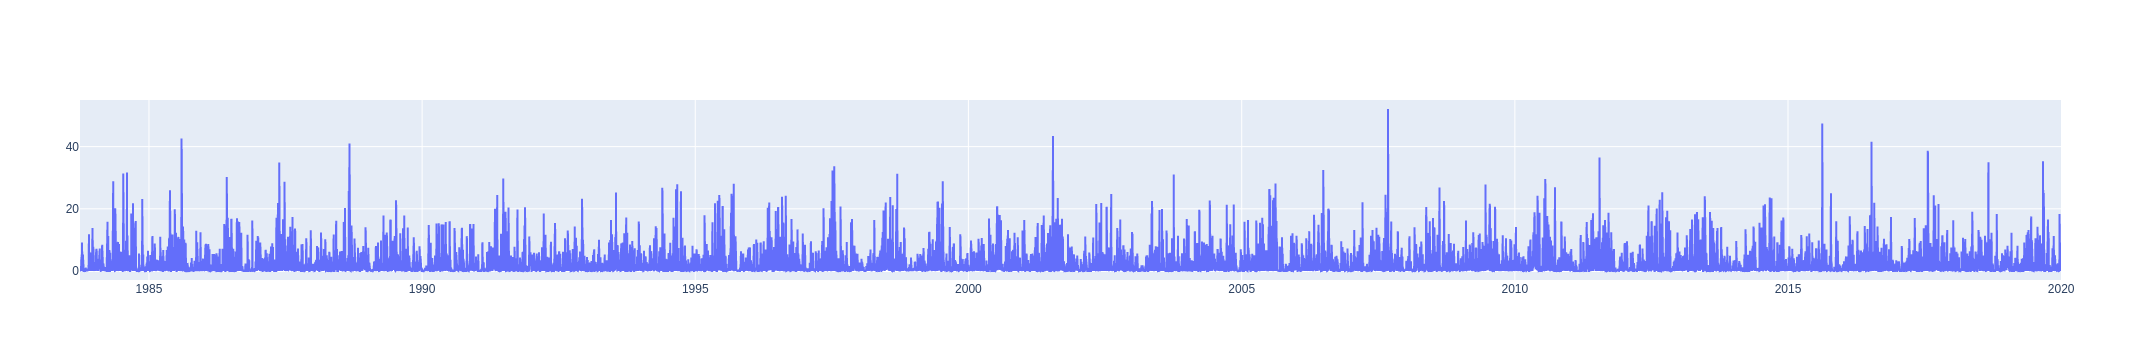

In [13]:
f.show()

## Data Correlation, Exploration

Text(0.5, 1.04, 'Example distribution for selected variables - Gauge ID_01')

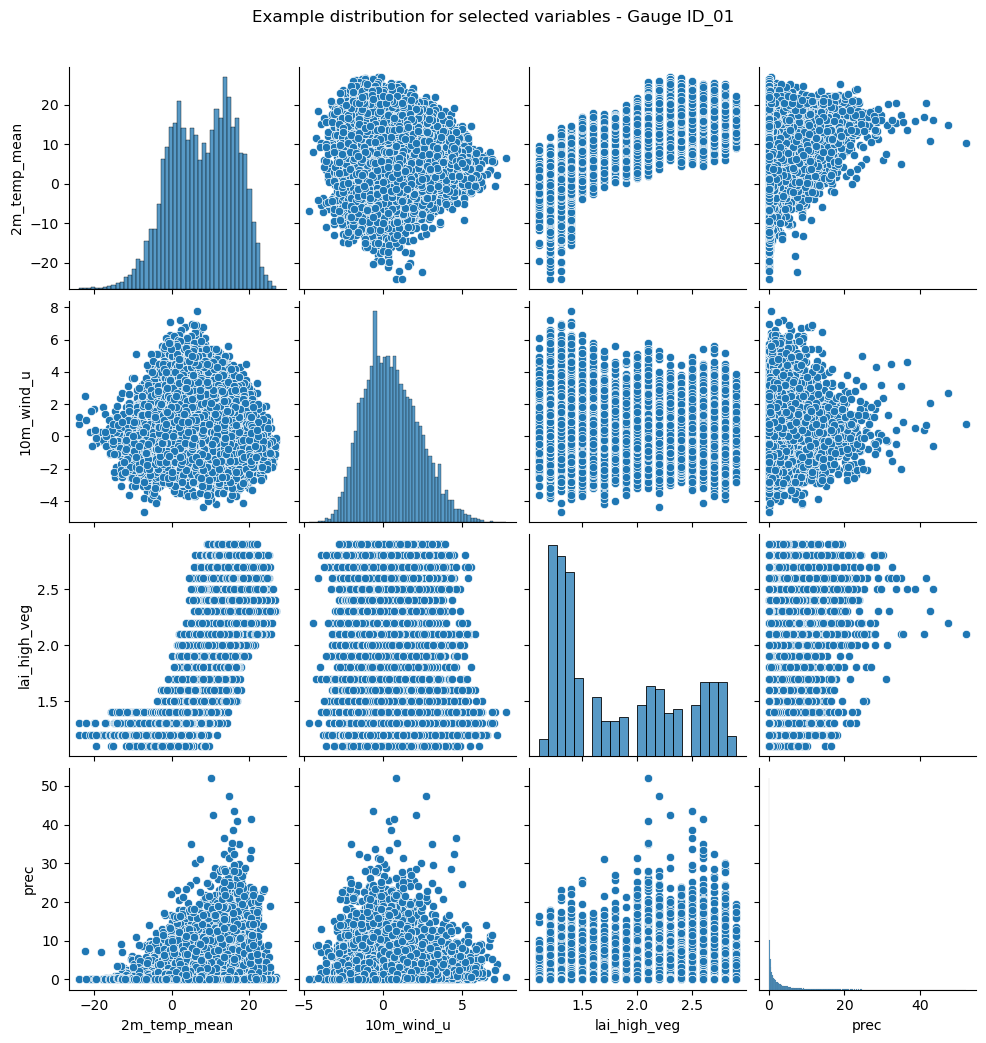

In [14]:
df_reduced = df[['2m_temp_mean','10m_wind_u','lai_high_veg','prec']]

import seaborn as sns
f = sns.pairplot(df_reduced)

f.fig.suptitle('Example distribution for selected variables - Gauge ID_01', y = 1.04)

# Machine Learning Models

The aim of the following section is to implement and use machine learning models to forecast the precipitation value, knowing th eseries of values up to the day the forecats is made.

We use the *sklearn* package for model implementation and the various functionalities to e.g. split the dataset into train and test sets, the RMS metrics, feature importance etc. 


## Preparing the dataset

In the following the prepare and pre-process the dataset.

We consider data from 100 randomly choosen gauges, where we input a fixed random seed for reproducibility purposes.

In [15]:
path = 'A_basins_total_upstrm/2_timeseries/daily'
files = glob.glob(path+'/*')



random_number=1
shuff = True
random.seed(random_number)
if shuff:
    random.shuffle(files)
    files = files[:100]
else:
    files=files[:100]
    
df_list = (pd.read_csv(file,delimiter=';') for file in files)
df   = pd.concat(df_list, ignore_index=True)

## Random Forest

In this case we consider the data as it is provided, without adding any additional variable.
We will consider a global dataset where all the data of the 100 gauges are combined, and split the dataset into train and test.

We use the *train_test_split()*

In [16]:
X_train, X_valid, y_train, y_valid= train_test_split(df.iloc[:, 0:-1],
                                                     df.iloc[:,-1],
                                                     test_size=0.3, 
                                                     random_state=random_number)

model=RandomForestRegressor(random_state=random_number,max_depth=10,n_jobs=-1)
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms = mean_squared_error(y_valid, y_pred, squared=False)
#print(rms)

/tmp/ipykernel_435704/258381522.py:7: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



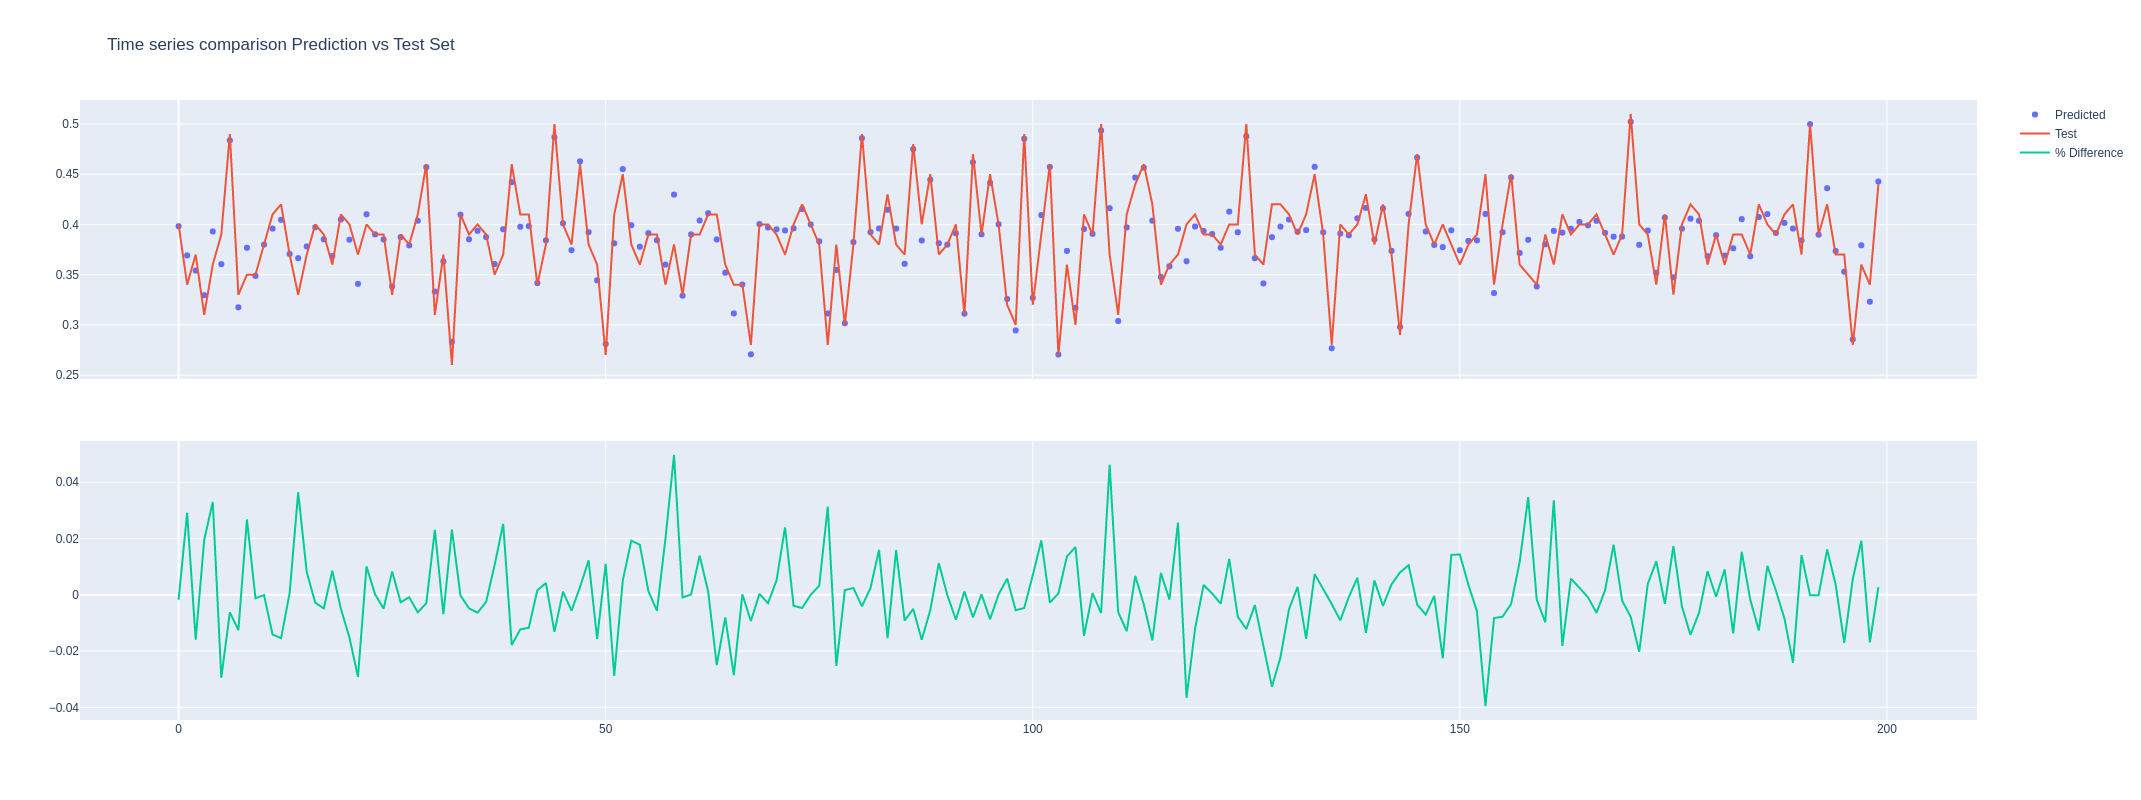

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create traces
fig = go.Figure()
y_pred = y_pred[:200]
y_valid = y_valid[:200]
fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1,
                   )

fig.add_trace(go.Scatter(x=list(range(len(y_pred))), y=y_pred,
                    mode='markers',
                    name='Predicted'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=list(range(len(y_pred))), y=y_valid,
                    mode='lines',
                    name='Test'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=list(range(len(y_pred))), y=y_pred - y_valid,
                    mode='lines',
                    name='% Difference'),
              row=2, col=1)


fig.update_layout( title = "Time series comparison Prediction vs Test Set",
                width=1500,
                height=800,
                             )

In [19]:
importance = model.feature_importances_

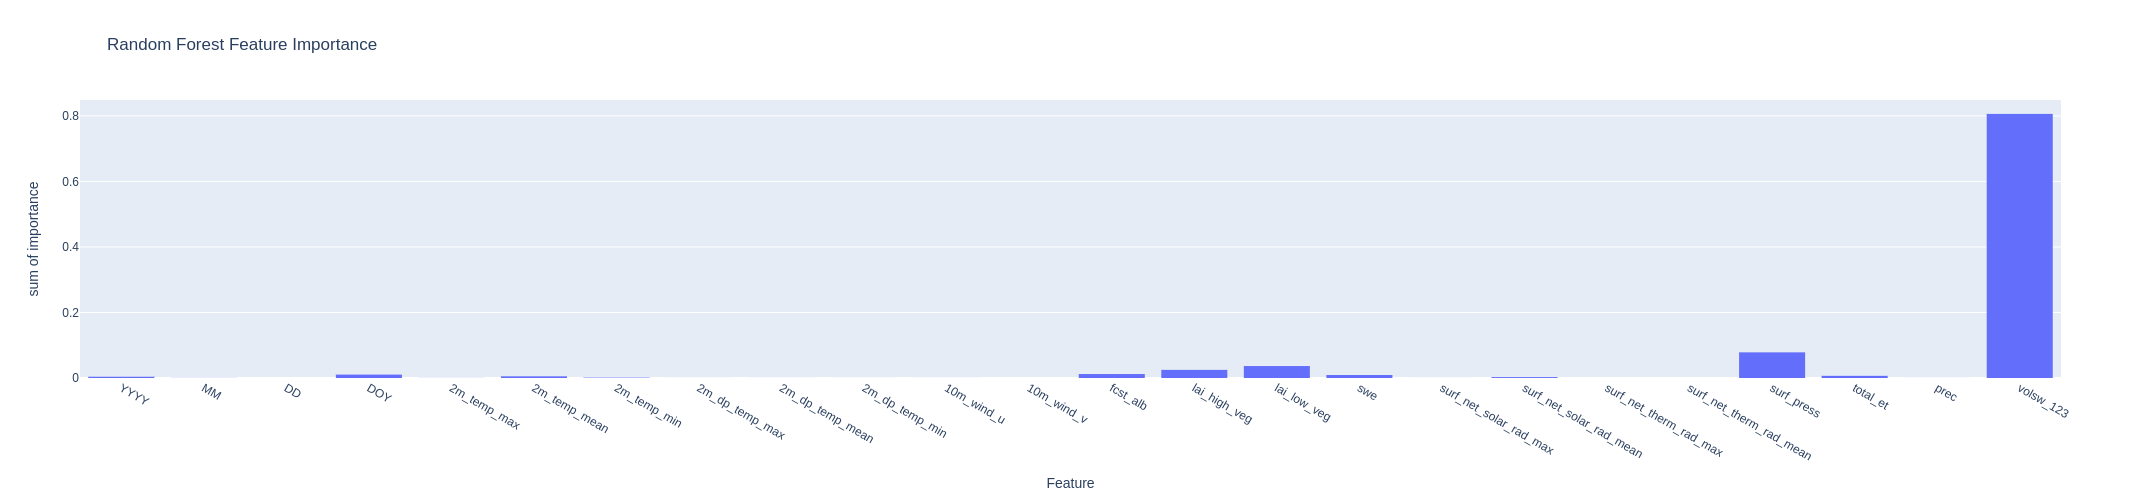

In [20]:
feature_importance=list(zip(importance, X_train.columns))
feature_importance_df=pd.DataFrame(feature_importance,columns=['importance',"Feature"])
fig = px.histogram(feature_importance_df, x="Feature",y='importance',
                  title = 'Random Forest Feature Importance')

fig.update_layout(
                width=1500,
                height=500,)
fig.show()

In [21]:
try:
    df = df.drop(columns = ['date_time'])
except:
    pass

X_train, X_valid, y_train, y_valid= train_test_split(df.iloc[:, 0:-1],
                                                     df.iloc[:,-1],
                                                     test_size=0.3, 
                                                     random_state=random_number)


# Ridge Regression

In [22]:
model=sklearn.linear_model.Ridge()
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms = mean_squared_error(y_valid, y_pred, squared=False)
print(rms)

0.022860252086448


### Here we can see coefficients of the ridge regression

In [23]:
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
print('Feature: %s, Score: %.4f' % (X_train.columns[i],v))

Feature: YYYY, Score: -0.0000
Feature: MM, Score: -0.0165
Feature: DD, Score: -0.0005
Feature: DOY, Score: 0.0005
Feature: 2m_temp_max, Score: 0.0013
Feature: 2m_temp_mean, Score: 0.0003
Feature: 2m_temp_min, Score: 0.0006
Feature: 2m_dp_temp_max, Score: -0.0007
Feature: 2m_dp_temp_mean, Score: -0.0008
Feature: 2m_dp_temp_min, Score: -0.0005
Feature: 10m_wind_u, Score: -0.0015
Feature: 10m_wind_v, Score: 0.0005
Feature: fcst_alb, Score: 0.0281
Feature: lai_high_veg, Score: 0.0027
Feature: lai_low_veg, Score: 0.0005
Feature: swe, Score: -0.0000
Feature: surf_net_solar_rad_max, Score: -0.0000
Feature: surf_net_solar_rad_mean, Score: -0.0001
Feature: surf_net_therm_rad_max, Score: -0.0000
Feature: surf_net_therm_rad_mean, Score: 0.0001
Feature: surf_press, Score: -0.0000
Feature: total_et, Score: 0.0087
Feature: prec, Score: -0.0000
Feature: volsw_123, Score: 0.7358


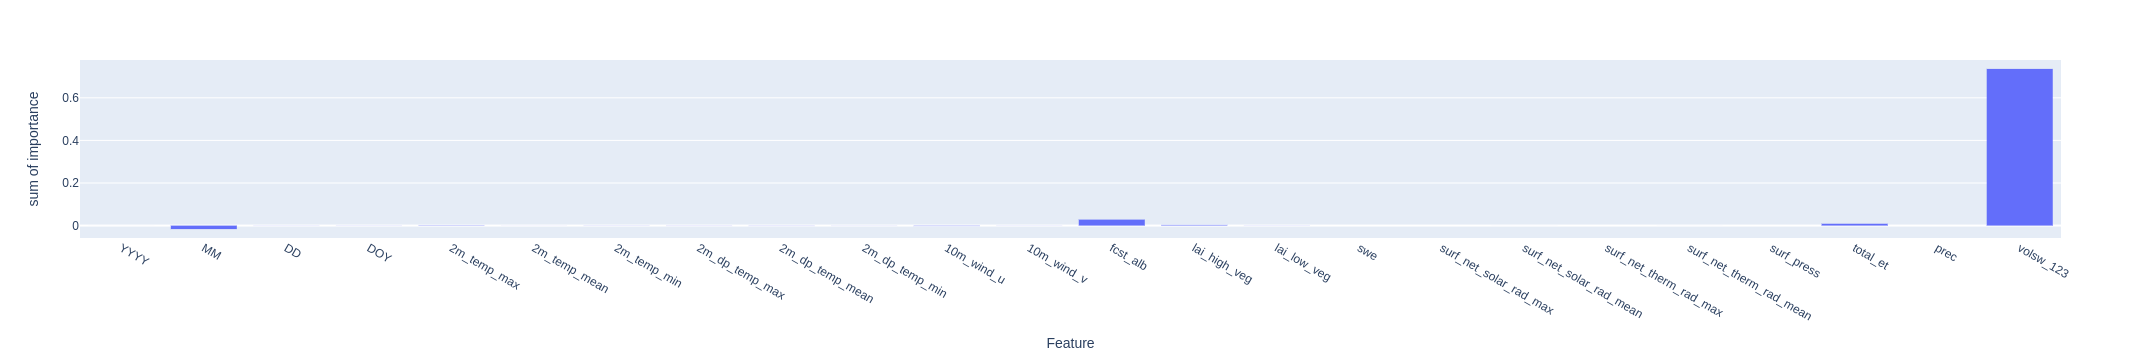

In [26]:
feature_importance=list(zip(importance, X_train.columns))
feature_importance_df=pd.DataFrame(feature_importance,columns=['importance',"Feature"])
fig = px.histogram(feature_importance_df, x="Feature",y='importance')
fig.show()

## K Neighbors Regressor

In [27]:
%%time
from sklearn.neighbors import KNeighborsRegressor
model=RandomForestRegressor(n_jobs=-1)
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms3 = mean_squared_error(y_valid, y_pred, squared=False)
print(rms3)

0.00743539679841898
CPU times: user 43min 42s, sys: 17.5 s, total: 43min 59s
Wall time: 32.2 s


## MLP Regressor

In [ ]:
%%time
from sklearn.neural_network import MLPRegressor
model=MLPRegressor(random_state=random_number)
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms4 = mean_squared_error(y_valid, y_pred, squared=False)
print(rms4)

## Histogram-based Gradient Boosting Regression

In [ ]:
%%time
from sklearn.ensemble import HistGradientBoostingRegressor
model=HistGradientBoostingRegressor(random_state=random_number)
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms5 = mean_squared_error(y_valid, y_pred, squared=False)
print(rms5)